#### Printing the first 5 lines of the tokenized dataset

In [ ]:
import json

file_path = "../Assignment_1/tokenizer/tokenized_gu_tokens.jsonl" #13 GB data, 52 lakh sentences approx

with open(file_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 5:  # stop after first 5
            break
        data = json.loads(line)
        print(f"Entry {i+1}:")
        print(data)   # or print(data['tokens']) if you stored tokens under "tokens"
        print("-" * 40)


        # observation: even lines are blank


Entry 1:
{'tokens': [['આ', 'વીડિયો', 'જુઓ', ':', 'ઊંઝા', 'માર્કેટયાર્ડ', 'આજથી', '25', 'જુલાઈ', 'સુધી', 'બંધ']]}
----------------------------------------
Entry 2:
{'tokens': []}
----------------------------------------
Entry 3:
{'tokens': [['મિથેનોલ', 'આવ્યો', 'ક્યાંથી', '?']]}
----------------------------------------
Entry 4:
{'tokens': []}
----------------------------------------
Entry 5:
{'tokens': [['આખરે', 'ત્રણ', 'રાજ્યોમાં', 'મળેલ', 'હાર', 'પર', 'કોંગ્રેસ', 'અધ્યક્ષ', 'રાહુલ', 'ગાંધી', 'દ્વારા', 'પ્રથમ', 'પ્રતિક્રિયા', 'આપવામાં', 'આવી', 'છે', '.'], ['તેમણે', 'કહ્યું', 'કે', ',', 'ત્રિપુરા', ',', 'નાગાલેન્ડ', 'અને', 'મેઘાલયમાં', 'લોકોના', 'જનાદેશનો', 'સ્વાગત', 'કરીએ', 'છે', 'અને', 'આ', 'ક્ષેત્રના', 'લોકોનો', 'વિશ્વાસ', 'ફરીથી', 'જીતીવા', 'માટે', 'પ્રતિબદ્ધ', 'છીએ', '.']]}
----------------------------------------


#### Loading the dataset

In [2]:
from collections import Counter, defaultdict
import json
import math
import random


In [3]:
def stream_tokenized_sentences(path, token_key="tokens", progress_interval=10000):
    """
    Generator that yields token lists (sentences) from a JSONL file.
    Handles nested structures like:
      {"tokens": [["a","b"], ["c","d"]]}
      {"tokens": ["a","b","c"]}
    """
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            line = line.strip()
            if not line:
                continue

            try:
                data = json.loads(line)
                tokens_data = data.get(token_key, [])

                # Case 1: tokens_data is a list of lists (multi-sentence entry)
                if len(tokens_data) > 0 and isinstance(tokens_data[0], list):
                    for sentence in tokens_data:
                        # ensure it's a flat list of strings
                        tokens = [str(t) for t in sentence if isinstance(t, (str, int, float))]
                        if tokens:
                            yield tokens

                # Case 2: tokens_data is a single list of tokens
                elif isinstance(tokens_data, list):
                    tokens = [str(t) for t in tokens_data if isinstance(t, (str, int, float))]
                    if tokens:
                        yield tokens

                # Case 3: fallback to text key if tokens are missing
                elif isinstance(data.get("text"), str):
                    yield data["text"].split()

                # Progress print every few thousand lines
                if (i + 1) % progress_interval == 0:
                    print(f"📄 Read {i+1:,} lines...")

            except json.JSONDecodeError:
                continue


In [4]:
def smoothed_prob(context, word, unigram_counts, context_counts, vocab, method="add_one", k=0.1):
    """
    Compute smoothed probability P(word | context)
    context: tuple of previous n-1 tokens
    """
    V = len(vocab)
    n = len(context) + 1

    # Unigram case
    if n == 1:
        count = unigram_counts.get(word, 0)
        if method == "add_one":
            return (count + 1) / (sum(unigram_counts.values()) + V)
        elif method == "add_k":
            return (count + k) / (sum(unigram_counts.values()) + k * V)
        elif method == "token_type":
            return (count + 1) / (V)
        else:
            return count / sum(unigram_counts.values())

    # Higher-order
    context_dict = context_counts.get(n, {})
    next_counts = context_dict.get(context, Counter())
    context_total = sum(next_counts.values())

    if method == "add_one":
        num = next_counts.get(word, 0) + 1
        denom = context_total + V
    elif method == "add_k":
        num = next_counts.get(word, 0) + k
        denom = context_total + k * V
    elif method == "token_type":
        num = next_counts.get(word, 0) + 1
        denom = V
    else:
        num = next_counts.get(word, 0)
        denom = context_total or 1

    return num / denom


In [5]:
def sentence_log_prob(sentence, unigram_counts, context_counts, vocab, n=4, method="add_one", k=0.1):
    """
    Compute total log-probability of a sentence under n-gram model with smoothing.
    """
    start_tok = "<s>"
    end_tok = "</s>"
    words = [start_tok] * (n-1) + sentence + [end_tok]
    log_p = 0.0

    for i in range(n-1, len(words)):
        context = tuple(words[i-n+1:i])
        word = words[i]
        p = smoothed_prob(context, word, unigram_counts, context_counts, vocab, method, k)
        log_p += math.log(p)
    return log_p


In [6]:
def reservoir_sample(path, sample_size=1000, token_key="tokens", seed=42):
    random.seed(seed)
    sample = []
    for i, sent in enumerate(stream_tokenized_sentences(path, token_key)):
        if i < sample_size:
            sample.append(sent)
        else:
            j = random.randint(0, i)
            if j < sample_size:
                sample[j] = sent
    return sample


In [7]:
def build_ngram_counts(path, max_n=4, add_sentence_tokens=True, limit=1_000_000, progress_interval=10_000):
    """
    Build n-gram frequency counts up to 4-gram.
    Processes at most `limit` sentences (default 1 million).
    Prints progress every `progress_interval` sentences.
    """
    assert 1 <= max_n <= 4
    unigram_counts = Counter()
    context_counts = {n: defaultdict(Counter) for n in range(2, max_n+1)}
    total_unigrams = 0
    vocab = set()

    start_tok = "<s>"
    end_tok = "</s>"

    for i, sent in enumerate(stream_tokenized_sentences(path)):
        if i >= limit:
            print(f"Stopped after {limit:,} sentences.")
            break

        # add sentence boundary tokens
        words = list(sent)
        if add_sentence_tokens:
            padded = [start_tok] * (max_n-1) + words + [end_tok]
        else:
            padded = words

        # unigrams
        for w in padded:
            unigram_counts[w] += 1
            total_unigrams += 1
            vocab.add(w)

        # higher order ngrams
        for n in range(2, max_n+1):
            for j in range(len(padded) - n + 1):
                context = tuple(padded[j:j + n - 1])
                next_tok = padded[j + n - 1]
                context_counts[n][context][next_tok] += 1

        #  progress print every 100k sentences
        if (i + 1) % progress_interval == 0:
            print(f"Processed {i+1:,} sentences...")

    print(f"Finished. Total sentences processed: {min(i+1, limit):,}")
    return unigram_counts, context_counts, total_unigrams, vocab


In [8]:
file_path = "../Assignment_1/tokenizer/tokenized_gu_tokens.jsonl"

print("Building n-gram counts (this may take a few minutes)...")
uni_counts, ctx_counts, total_unigrams, vocab = build_ngram_counts(
    file_path,
    max_n=4,
    limit=1_000_000,           # ✅ only process 10 lakh
    progress_interval=10_000  # ✅ print progress every 10000
)
print(f"Done! Vocabulary size: {len(vocab)}, Total tokens: {total_unigrams:,}")

print("Sampling 1000 random sentences...")
sample_sentences = reservoir_sample(file_path, sample_size=1000)
print("Sampled 1000 sentences.")

# Evaluate a few examples
methods = ["add_one", "add_k", "token_type"]
for m in methods:
    print(f"\n=== {m.upper()} Smoothing ===")
    for i, sent in enumerate(sample_sentences[:3]):  # print first 3 only
        logp = sentence_log_prob(sent, uni_counts, ctx_counts, vocab, n=4, method=m)
        print(f"Sentence {i+1}: {' '.join(sent[:10])}... -> logP = {logp:.4f}")


Building n-gram counts (this may take a few minutes)...
Processed 10,000 sentences...
📄 Read 10,000 lines...
Processed 20,000 sentences...
📄 Read 20,000 lines...
Processed 30,000 sentences...
Processed 40,000 sentences...
📄 Read 30,000 lines...
Processed 50,000 sentences...
📄 Read 40,000 lines...
Processed 60,000 sentences...
📄 Read 50,000 lines...
Processed 70,000 sentences...
Processed 80,000 sentences...
📄 Read 60,000 lines...
Processed 90,000 sentences...
📄 Read 70,000 lines...
Processed 100,000 sentences...
Processed 110,000 sentences...
📄 Read 80,000 lines...
Processed 120,000 sentences...
📄 Read 90,000 lines...
Processed 130,000 sentences...
📄 Read 100,000 lines...
Processed 140,000 sentences...
Processed 150,000 sentences...
📄 Read 110,000 lines...
Processed 160,000 sentences...
📄 Read 120,000 lines...
Processed 170,000 sentences...
Processed 180,000 sentences...
📄 Read 130,000 lines...
Processed 190,000 sentences...
📄 Read 140,000 lines...
Processed 200,000 sentences...
📄 Read


Evaluating log-probabilities for all 1000 sentences...
✅ Computed all log-probabilities!


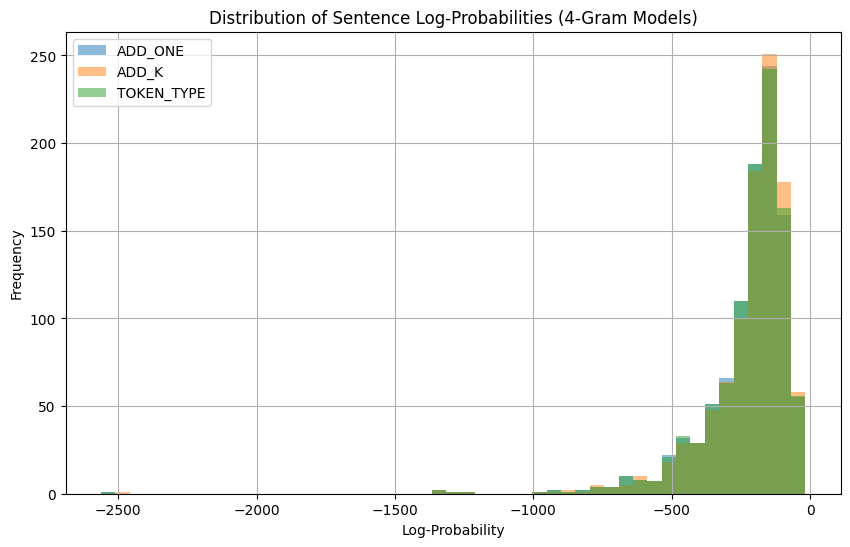

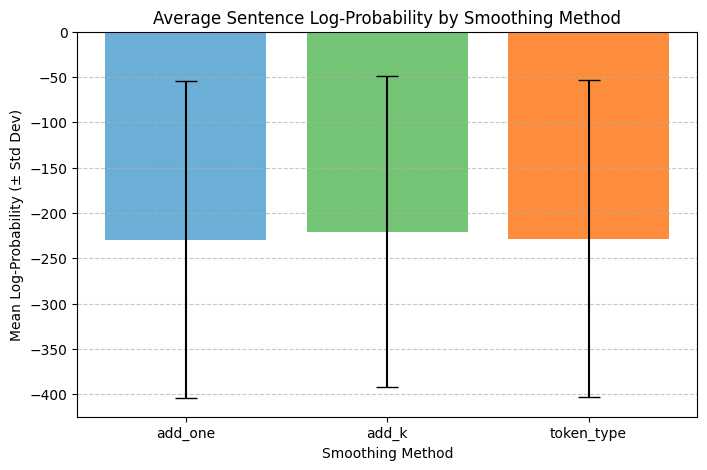

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# ======================================================
#  Collect log-probabilities for all sample sentences
# ======================================================
results = {m: [] for m in methods}

print("\nEvaluating log-probabilities for all 1000 sentences...")
for m in methods:
    for sent in sample_sentences:
        logp = sentence_log_prob(sent, uni_counts, ctx_counts, vocab, n=4, method=m)
        results[m].append(logp)

print("✅ Computed all log-probabilities!")

# ======================================================
# 📊 Plot distribution of log-probabilities
# ======================================================
plt.figure(figsize=(10, 6))
bins = np.linspace(min(min(v) for v in results.values()), max(max(v) for v in results.values()), 50)

for m, vals in results.items():
    plt.hist(vals, bins=bins, alpha=0.5, label=m.upper())

plt.title("Distribution of Sentence Log-Probabilities (4-Gram Models)")
plt.xlabel("Log-Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# ======================================================
# 📉 Compare mean and variance across smoothing methods
# ======================================================
means = [np.mean(results[m]) for m in methods]
stds = [np.std(results[m]) for m in methods]

plt.figure(figsize=(8, 5))
plt.bar(methods, means, yerr=stds, capsize=8, color=['#6baed6', '#74c476', '#fd8d3c'])
plt.title("Average Sentence Log-Probability by Smoothing Method")
plt.xlabel("Smoothing Method")
plt.ylabel("Mean Log-Probability (± Std Dev)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


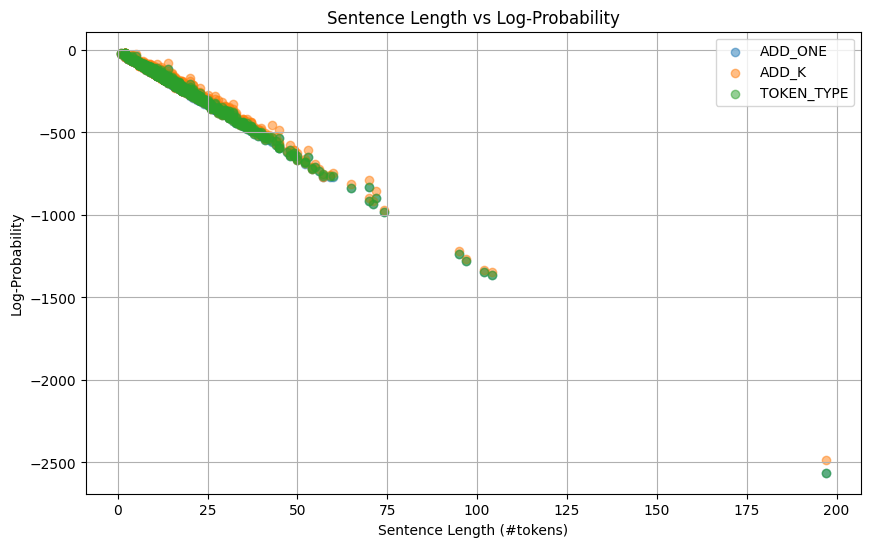

In [10]:
lengths = [len(s) for s in sample_sentences]

plt.figure(figsize=(10, 6))
for m in methods:
    plt.scatter(lengths, results[m], alpha=0.5, label=m.upper())

plt.title("Sentence Length vs Log-Probability")
plt.xlabel("Sentence Length (#tokens)")
plt.ylabel("Log-Probability")
plt.legend()
plt.grid(True)
plt.show()


Calculating unigram sentence log-probabilities...
Calculating bigram sentence log-probabilities...
Calculating trigram sentence log-probabilities...
Calculating quadrigram sentence log-probabilities...


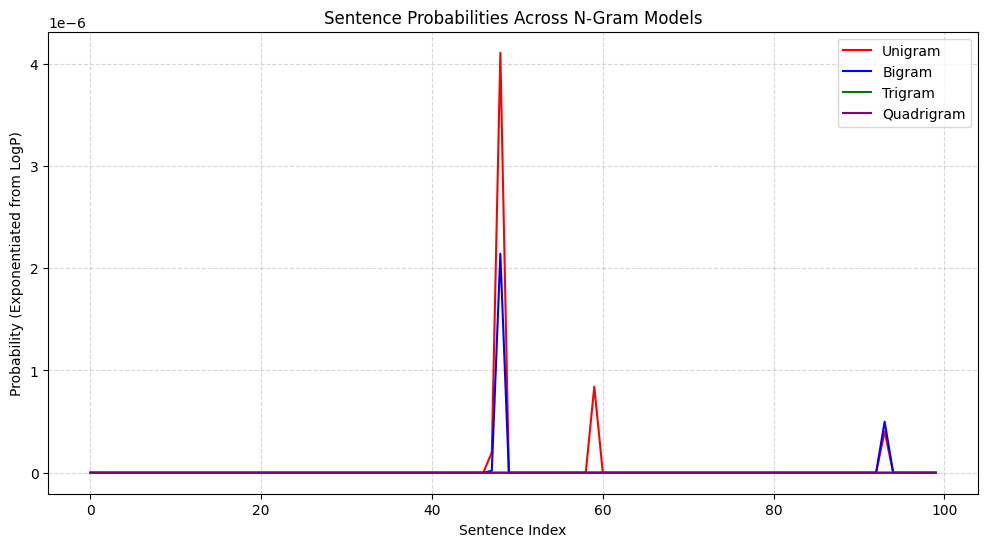

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 1️⃣ Compute log-probabilities per model
# -------------------------------

test_sentences = sample_sentences[:100]   # limit to 100 for speed
models = ["unigram", "bigram", "trigram", "quadrigram"]
model_n = {"unigram": 1, "bigram": 2, "trigram": 3, "quadrigram": 4}

log_probs = {m: [] for m in models}

for m in models:
    print(f"Calculating {m} sentence log-probabilities...")
    n = model_n[m]
    for sent in test_sentences:
        lp = sentence_log_prob(
            sent,
            uni_counts,
            ctx_counts,
            vocab,
            n=n,
            method="add_one"   # you can also try "add_k" or "token_type"
        )
        log_probs[m].append(lp)

# -------------------------------
# 2️⃣ Convert to probabilities
# -------------------------------
# Since logP can be very negative, we exponentiate safely
probs = {m: [np.exp(lp) if lp > -700 else 0 for lp in vals] for m, vals in log_probs.items()}

# -------------------------------
# 3️⃣ Plot comparisons
# -------------------------------
plt.figure(figsize=(12,6))
for m, color in zip(models, ["red", "blue", "green", "purple"]):
    plt.plot(probs[m], label=m.title(), color=color)

plt.title("Sentence Probabilities Across N-Gram Models")
plt.xlabel("Sentence Index")
plt.ylabel("Probability (Exponentiated from LogP)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


Computing probabilities for sample sentences...
Processed 100/1000 sentences...
Processed 200/1000 sentences...
Processed 300/1000 sentences...
Processed 400/1000 sentences...
Processed 500/1000 sentences...
Processed 600/1000 sentences...
Processed 700/1000 sentences...
Processed 800/1000 sentences...
Processed 900/1000 sentences...
Processed 1000/1000 sentences...
✅ Done computing probabilities!


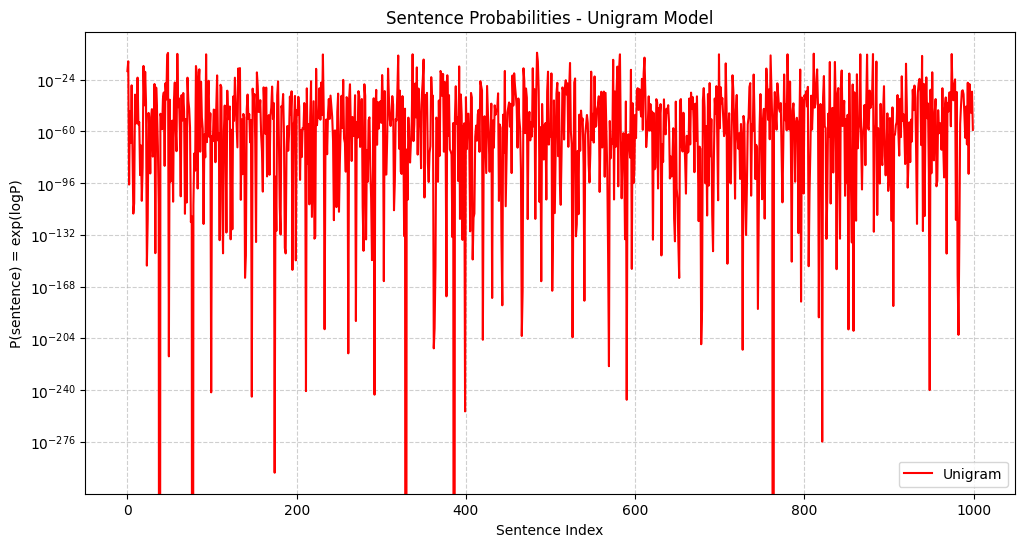

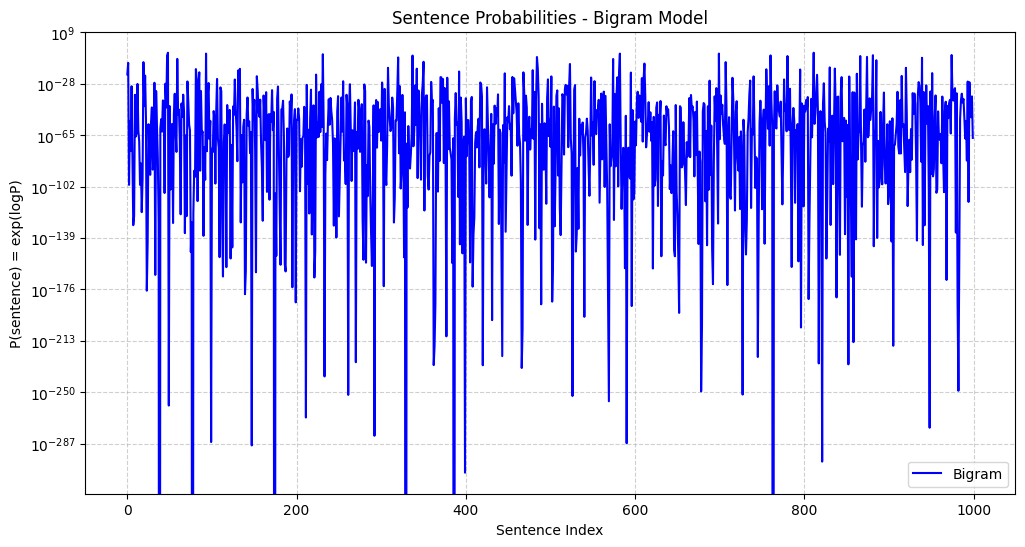

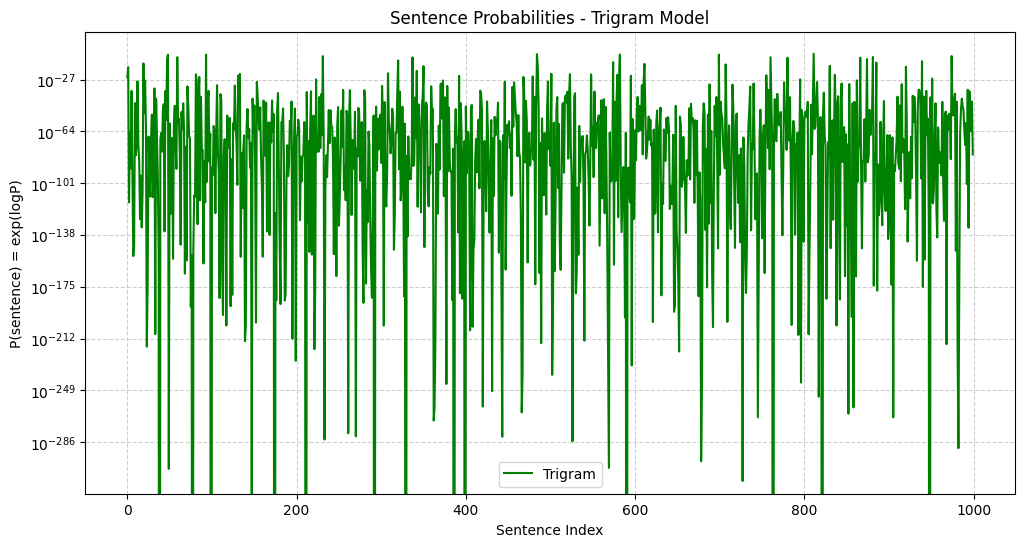

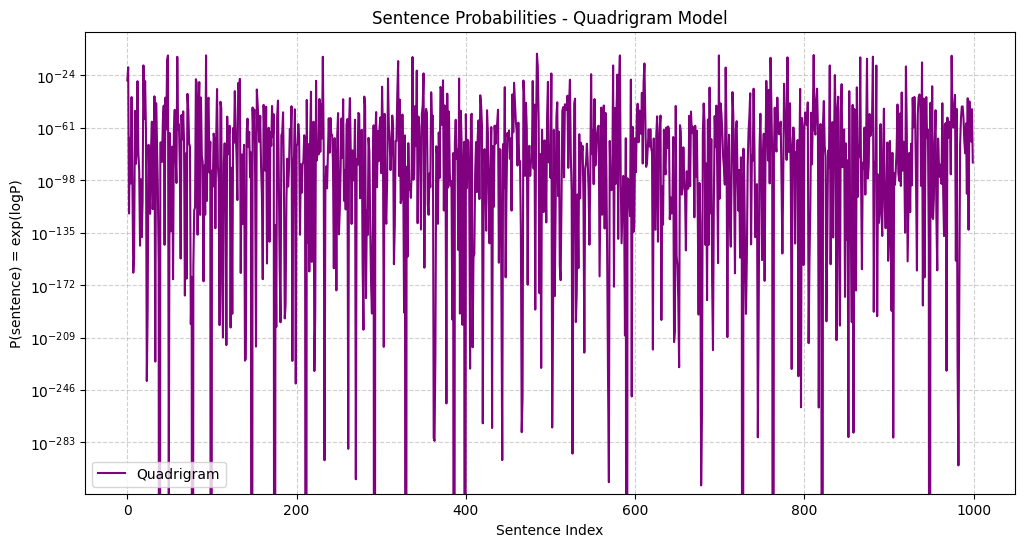

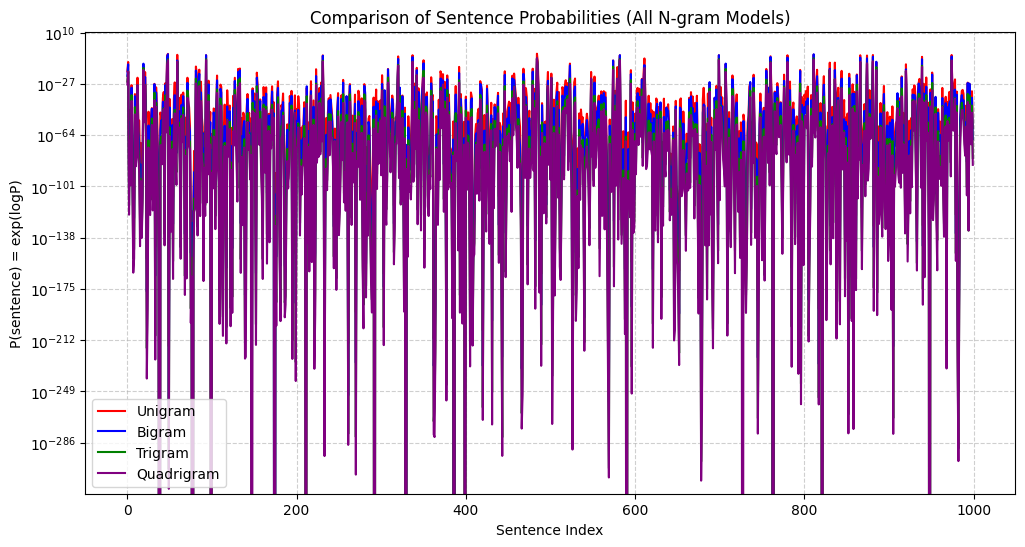

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# ================================================================
# 🧩 Compute sentence log-probabilities for all 4 n-gram models
# ================================================================
print("Computing probabilities for sample sentences...")

unigram_logP = []
bigram_logP = []
trigram_logP = []
quadgram_logP = []

for i, sent in enumerate(sample_sentences):
    unigram_logP.append(sentence_log_prob(sent, uni_counts, ctx_counts, vocab, n=1))
    bigram_logP.append(sentence_log_prob(sent, uni_counts, ctx_counts, vocab, n=2))
    trigram_logP.append(sentence_log_prob(sent, uni_counts, ctx_counts, vocab, n=3))
    quadgram_logP.append(sentence_log_prob(sent, uni_counts, ctx_counts, vocab, n=4))
    if (i + 1) % 100 == 0:
        print(f"Processed {i+1}/1000 sentences...")

print("✅ Done computing probabilities!")

# ================================================================
# 📈 Plot 4 Graphs Individually
# ================================================================
plt.figure(figsize=(12,6))
plt.plot(np.exp(unigram_logP), color='red', label='Unigram')
plt.title("Sentence Probabilities - Unigram Model")
plt.xlabel("Sentence Index")
plt.ylabel("P(sentence) = exp(logP)")
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(np.exp(bigram_logP), color='blue', label='Bigram')
plt.title("Sentence Probabilities - Bigram Model")
plt.xlabel("Sentence Index")
plt.ylabel("P(sentence) = exp(logP)")
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(np.exp(trigram_logP), color='green', label='Trigram')
plt.title("Sentence Probabilities - Trigram Model")
plt.xlabel("Sentence Index")
plt.ylabel("P(sentence) = exp(logP)")
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(np.exp(quadgram_logP), color='purple', label='Quadrigram')
plt.title("Sentence Probabilities - Quadrigram Model")
plt.xlabel("Sentence Index")
plt.ylabel("P(sentence) = exp(logP)")
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ================================================================
# 🧭 Optional Combined Comparison
# ================================================================
plt.figure(figsize=(12,6))
plt.plot(np.exp(unigram_logP), color='red', label='Unigram')
plt.plot(np.exp(bigram_logP), color='blue', label='Bigram')
plt.plot(np.exp(trigram_logP), color='green', label='Trigram')
plt.plot(np.exp(quadgram_logP), color='purple', label='Quadrigram')
plt.title("Comparison of Sentence Probabilities (All N-gram Models)")
plt.xlabel("Sentence Index")
plt.ylabel("P(sentence) = exp(logP)")
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
